# Task - 1 - Natural Language Inference (NLI)

## 1.Install Necessary Libraries

In [1]:
!pip install -q peft transformers accelerate bitsandbytes datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 20.4 MB/s eta 0:00:00:00:0100:01


## 2.Preprocessing the data files

In [2]:
import pandas as pd
import re

def extract_sentence(parse_str):
    return ' '.join(re.findall(r'\b\w+\b', str(parse_str)))

def preprocess_dataset(path):
    df = pd.read_csv(path, sep='\t')
    df = df.dropna(subset=['Label'])  # ✅ Drop rows with missing labels
    df['premise'] = df['Sent1_parse'].apply(extract_sentence)
    df['hypothesis'] = df['Sent2_parse'].apply(extract_sentence)
    return df[['premise', 'hypothesis', 'Label']] 

# Set your paths here
train_path = '/kaggle/input/recognizing-textual-entailment-rte/train.tsv'
val_path = '/kaggle/input/recognizing-textual-entailment-rte/dev.tsv'
test_path = '/kaggle/input/recognizing-textual-entailment-rte/test.tsv'

# Preprocess
train_df = preprocess_dataset(train_path)
val_df = preprocess_dataset(val_path)
test_df = preprocess_dataset(test_path)

# Define valid labels
label2id = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
id2label = {v: k for k, v in label2id.items()}
valid_labels = set(label2id.keys())

# Drop rows with invalid or missing labels
train_df = train_df[train_df['Label'].isin(valid_labels)].copy()
val_df = val_df[val_df['Label'].isin(valid_labels)].copy()
test_df = test_df[test_df['Label'].isin(valid_labels)].copy()

# Now map safely and cast to int
train_df['label'] = train_df['Label'].map(label2id).astype(int)
val_df['label'] = val_df['Label'].map(label2id).astype(int)
test_df['label'] = test_df['Label'].map(label2id).astype(int)




In [8]:
print(train_df['label'].unique())  # should print [0 1 2]
print(train_df['label'].dtype)  

[2 1 0]
int64


## 3. Tokenization & Dataset Setup

In [3]:
from datasets import Dataset
from transformers import AutoTokenizer



train_dataset = Dataset.from_pandas(train_df[['premise', 'hypothesis', 'label']])
val_dataset = Dataset.from_pandas(val_df[['premise', 'hypothesis', 'label']])
test_dataset = Dataset.from_pandas(test_df[['premise', 'hypothesis', 'label']])

MODEL_NAME = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(example):
    return tokenizer(example["premise"], example["hypothesis"], truncation=True, padding="max_length")

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

## 4. Tuning the hyperparameters using a Hybrid approach of sequential tuning and BOHB

In [ ]:
import os
import numpy as np
import torch
import gc
import time
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from functools import partial
import optuna
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler

def force_gpu_cleanup():
    """Force aggressive GPU memory cleanup"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        
        # Print memory stats for monitoring
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU memory - Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB")

def run_sequential_phase(train_dataset, val_dataset, tokenizer, id2label, label2id, n_trials=3): 
    """
    Run initial sequential hyperparameter exploration to find stable, promising regions
    """
    print("=" * 60)
    print("🔍 Phase 1: Sequential exploration")
    print("=" * 60)
    
    # Force GPU cleanup
    force_gpu_cleanup()
    
    
    lr_options = [1e-5, 3e-5, 5e-5]
    batch_options = [16, 32, 64]
    epochs_options = [1, 2]
    wd_options = [0.0, 0.01, 0.1]
    
    # Create parameter combinations
    params_list = []
    for lr in lr_options:
        for bs in batch_options:
            
            params_list.append({
                "learning_rate": lr,
                "batch_size": bs,
                "num_epochs": 1,
                "weight_decay": 0.01
            })
    
    
    np.random.seed(42)
    if len(params_list) > n_trials:
        params_list = list(np.random.choice(params_list, n_trials, replace=False))
    
    # Track results
    results = []
    
    # Run each trial sequentially
    for trial_idx, params in enumerate(params_list):
        
        force_gpu_cleanup()
        
        print(f"\n🔄 Sequential Trial {trial_idx+1}/{len(params_list)}")
        print(f"Parameters: {params}")
        
        # Small sample for quick exploration (5%)
        sample_ratio = 0.05
        sample_size = int(len(train_dataset) * sample_ratio)
        indices = np.random.choice(len(train_dataset), sample_size, replace=False)
        train_subset = train_dataset.select(indices)
        print(f"Using {len(train_subset)} examples ({sample_ratio*100:.1f}% of data)")
        
        try:
            # Create model
            model = AutoModelForSequenceClassification.from_pretrained(
                "bert-base-uncased",  
                num_labels=len(id2label),
                id2label=id2label,
                label2id=label2id
            )
            
            # Move to GPU
            if torch.cuda.is_available():
                model = model.cuda()
                print(f"Model on CUDA: {next(model.parameters()).is_cuda}")
            
            # Define metric
            def compute_metrics(eval_pred):
                logits, labels = eval_pred
                preds = np.argmax(logits, axis=-1)
                acc = accuracy_score(labels, preds)
                return {"accuracy": acc}
            
            # Training args
            training_args = TrainingArguments(
                output_dir=f"/content/seq_trial_{trial_idx}",
                evaluation_strategy="epoch",
                save_strategy="no",
                num_train_epochs=params["num_epochs"],
                per_device_train_batch_size=params["batch_size"],
                per_device_eval_batch_size=params["batch_size"],
                learning_rate=params["learning_rate"],
                weight_decay=params["weight_decay"],
                report_to="none",
                fp16=False,  # Disable mixed precision for stability
                dataloader_num_workers=0,
                logging_steps=100
            )
            
            # Create trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                tokenizer=tokenizer,
                train_dataset=train_subset,
                eval_dataset=val_dataset,
                compute_metrics=compute_metrics
            )
            
            # Train
            start_time = time.time()
            trainer.train()
            train_time = time.time() - start_time
            
            # Evaluate
            eval_result = trainer.evaluate()
            accuracy = eval_result["eval_accuracy"]
            
            print(f"Accuracy: {accuracy:.4f}, Time: {train_time:.1f}s")
            
            # Store result
            results.append({
                "params": params,
                "accuracy": accuracy,
                "time": train_time
            })
            
        except Exception as e:
            print(f"❌ Error in trial {trial_idx}: {str(e)}")
        finally:
            # Clean up
            if 'model' in locals():
                del model
            if 'trainer' in locals():
                del trainer
            force_gpu_cleanup()
            time.sleep(1)  
    
    # Sort results by accuracy
    results.sort(key=lambda x: x["accuracy"], reverse=True)
    
    print("\n=== Sequential Phase Results ===")
    for i, result in enumerate(results):
        print(f"{i+1}. Accuracy: {result['accuracy']:.4f}, LR: {result['params']['learning_rate']}, BS: {result['params']['batch_size']}")
    
    # Extract best parameter ranges for BOHB
    if len(results) > 0:
        # Get the top half of results or at least 2
        top_count = max(len(results) // 2, min(2, len(results)))
        top_results = results[:top_count]
        
        # Extract parameter ranges
        lr_values = [r["params"]["learning_rate"] for r in top_results]
        bs_values = [r["params"]["batch_size"] for r in top_results]
        
        # Determine ranges
        lr_low, lr_high = min(lr_values), max(lr_values)
        bs_options = list(set(bs_values))  # Unique batch sizes
        
        # If all same value, expand slightly
        if lr_low == lr_high:
            lr_low = lr_low * 0.8
            lr_high = lr_high * 1.2
            
        bohb_ranges = {
            "lr_range": (lr_low, lr_high),
            "batch_sizes": bs_options,
            "weight_decay_range": (0.0, 0.1)
        }
        
        return bohb_ranges, results
    else:
        # Default ranges if no successful trials
        return {
            "lr_range": (1e-5, 5e-5),
            "batch_sizes": [16, 32],
            "weight_decay_range": (0.0, 0.1)
        }, []

def bohb_objective(trial, train_dataset, val_dataset, tokenizer, id2label, label2id, param_ranges):
    """Objective function for BOHB optimization with refined parameter ranges"""
    # Force GPU cleanup
    force_gpu_cleanup()
    
    print(f"\n🎯 Starting BOHB Trial #{trial.number}")
    
    # Get parameter ranges from sequential phase
    lr_range = param_ranges["lr_range"]
    batch_sizes = param_ranges["batch_sizes"]
    wd_range = param_ranges["weight_decay_range"]
    
    # Suggest hyperparameters within refined ranges
    learning_rate = trial.suggest_float("learning_rate", lr_range[0], lr_range[1], log=True)
    batch_size = trial.suggest_categorical("batch_size", batch_sizes)
    num_epochs = 1  # Fixed to 1 epoch for all BOHB trials
    weight_decay = trial.suggest_float("weight_decay", wd_range[0], wd_range[1])
    
    # Progressive sampling
    if trial.number < 2:
        sample_ratio = 0.05  # 5% for first 2 trials
    else:
        sample_ratio = 0.10  # 10% for remaining trials
    
    train_subset_size = int(sample_ratio * len(train_dataset))
    
    # Simple random sampling
    indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
    train_subset = train_dataset.select(indices)
    print(f"📊 Sampled {len(train_subset)} examples ({sample_ratio*100:.1f}% of dataset)")
    
    # Define metrics function
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average="macro")
        return {"accuracy": acc, "f1_macro": f1}
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"/content/bohb_trial_{trial.number}",
        evaluation_strategy="epoch",
        save_strategy="no",
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        report_to="none",
        fp16=False, 
        dataloader_num_workers=0,
        dataloader_pin_memory=True
    )
    
    try:
        # Create model
        model = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased",  
            num_labels=len(id2label),
            id2label=id2label,
            label2id=label2id
        )
        
        # Move to GPU
        if torch.cuda.is_available():
            model = model.cuda()
        
        trainer = Trainer(
            model=model,
            args=training_args,
            tokenizer=tokenizer,
            train_dataset=train_subset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics
        )
        
        # Train
        start_time = time.time()
        trainer.train()
        train_time = time.time() - start_time
        print(f"✅ Training completed in {train_time:.2f} seconds")
        
        # Evaluate
        metrics = trainer.evaluate()
        acc = metrics["eval_accuracy"]
        
        # Report accuracy for pruning
        trial.report(acc, step=num_epochs)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return acc
        
    except optuna.exceptions.TrialPruned:
        print(f"Trial #{trial.number} pruned.")
        raise
    except Exception as e:
        print(f"❌ BOHB Trial {trial.number} failed: {str(e)}")
        raise e
    finally:
        # Clean up
        if 'model' in locals():
            del model
        if 'trainer' in locals():
            del trainer
        force_gpu_cleanup()

def run_bohb_phase(train_dataset, val_dataset, tokenizer, id2label, label2id, param_ranges, n_trials=4): 
    """Run BOHB phase with refined parameter ranges"""
    print("=" * 60)
    print("🚀 Phase 2: BOHB optimization with refined parameter ranges")
    print("=" * 60)
    
    # Print refined ranges
    print(f"Learning rate range: {param_ranges['lr_range'][0]:.6f} to {param_ranges['lr_range'][1]:.6f}")
    print(f"Batch sizes: {param_ranges['batch_sizes']}")
    print(f"Weight decay range: {param_ranges['weight_decay_range'][0]:.4f} to {param_ranges['weight_decay_range'][1]:.4f}")
    
    # Setup pruner and sampler
    pruner = HyperbandPruner(min_resource=1, max_resource=1, reduction_factor=3)  
    sampler = TPESampler(n_startup_trials=1, seed=42)
    
    # Create study
    study = optuna.create_study(
        direction="maximize",
        sampler=sampler,
        pruner=pruner,
        study_name="bohb_refined_optimization"
    )
    
    # Create objective function with parameter ranges
    objective_func = partial(
        bohb_objective,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        tokenizer=tokenizer,
        id2label=id2label,
        label2id=label2id,
        param_ranges=param_ranges
    )
    
    # Run optimization
    start = time.time()
    try:
        study.optimize(
            objective_func, 
            n_trials=n_trials,
            timeout=1800,  
            catch=(Exception,)
        )
    except KeyboardInterrupt:
        print("Optimization stopped by user.")
    
    duration = time.time() - start
    
    # Print results
    if len(study.trials) > 0:
        print("\n🎯 BOHB Phase Best Trial")
        print(f"Trial #{study.best_trial.number}")
        print(f"Accuracy: {study.best_value:.4f}")
        print("Best Hyperparameters:")
        for k, v in study.best_trial.params.items():
            print(f"  {k}: {v}")
        print(f"⏱️ Optimization Time: {duration:.2f} seconds")
        
        return study.best_trial.params
    else:
        print("No successful BOHB trials")
        return None

def run_hybrid_tuning(train_dataset, val_dataset, tokenizer, id2label, label2id):
    """Run the complete hybrid tuning process"""
    print("=" * 60)
    print("🔄 Starting hybrid hyperparameter tuning")
    print("=" * 60)
    
    # Phase 1: Sequential tuning to find stable parameter ranges
    param_ranges, seq_results = run_sequential_phase(
        train_dataset, 
        val_dataset, 
        tokenizer, 
        id2label, 
        label2id, 
        n_trials=3  
    )
    
    
    if len(seq_results) == 0:
        print("❌ No successful sequential trials. Using default parameters.")
        return {
            "learning_rate": 2e-5,
            "batch_size": 16,
            "num_epochs": 2,
            "weight_decay": 0.01
        }
    
    # Phase 2: BOHB within refined parameter ranges
    bohb_params = run_bohb_phase(
        train_dataset, 
        val_dataset, 
        tokenizer, 
        id2label, 
        label2id, 
        param_ranges,
        n_trials=4 
    )
    
    # If BOHB fails, use best from sequential phase
    if bohb_params is None:
        print("Using best parameters from sequential phase")
        best_params = seq_results[0]["params"]
    else:
        best_params = bohb_params
        best_params["num_epochs"] = 2  
    
    print("\n=== Final Hyperparameter Tuning Results ===")
    print(f"Best parameters: {best_params}")
    
    return best_params

# Execute the hybrid tuning
best_params = run_hybrid_tuning(
    train_dataset=train_dataset, 
    val_dataset=val_dataset, 
    tokenizer=tokenizer, 
    id2label=id2label, 
    label2id=label2id
)

print("\nFinal best parameters to use for full model training:")
for param_name, param_value in best_params.items():
    print(f"  {param_name}: {param_value}")

🔄 Starting hybrid hyperparameter tuning
🔍 Phase 1: Sequential exploration
GPU memory - Allocated: 0.00 MB, Reserved: 0.00 MB
GPU memory - Allocated: 0.00 MB, Reserved: 0.00 MB

🔄 Sequential Trial 1/3
Parameters: {'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 1, 'weight_decay': 0.01}
Using 27468 examples (5.0% of data)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model on CUDA: True


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-6eee85b208c8>:114: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.639000,0.571431,0.770575


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Accuracy: 0.7706, Time: 1619.0s
GPU memory - Allocated: 1298.25 MB, Reserved: 1824.00 MB


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU memory - Allocated: 1298.25 MB, Reserved: 1824.00 MB

🔄 Sequential Trial 2/3
Parameters: {'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 1, 'weight_decay': 0.01}
Using 27468 examples (5.0% of data)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Model on CUDA: True


<ipython-input-4-6eee85b208c8>:114: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.784700,0.710808,0.701890


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Accuracy: 0.7019, Time: 1630.6s
GPU memory - Allocated: 1297.30 MB, Reserved: 2180.00 MB


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU memory - Allocated: 1297.30 MB, Reserved: 2180.00 MB

🔄 Sequential Trial 3/3
Parameters: {'learning_rate': 3e-05, 'batch_size': 64, 'num_epochs': 1, 'weight_decay': 0.01}
Using 27468 examples (5.0% of data)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-6eee85b208c8>:114: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Model on CUDA: True
❌ Error in trial 2: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/parallel_apply.py", line 96, in _worker
    output = module(*input, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_bert.py", line 1668, in forward
    outputs = self.bert(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args,

[I 2025-04-01 18:25:35,500] A new study created in memory with name: bohb_refined_optimization



=== Sequential Phase Results ===
1. Accuracy: 0.7706, LR: 5e-05, BS: 32
2. Accuracy: 0.7019, LR: 1e-05, BS: 32
🚀 Phase 2: BOHB optimization with refined parameter ranges
Learning rate range: 0.000010 to 0.000050
Batch sizes: [32]
Weight decay range: 0.0000 to 0.1000
GPU memory - Allocated: 16.40 MB, Reserved: 68.00 MB

🎯 Starting BOHB Trial #0
📊 Sampled 27468 examples (5.0% of dataset)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-6eee85b208c8>:261: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.609629,0.752794,0.751901


✅ Training completed in 1631.06 seconds


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[I 2025-04-01 18:55:53,023] Trial 0 finished with value: 0.7527941475309896 and parameters: {'learning_rate': 1.827226177606625e-05, 'batch_size': 32, 'weight_decay': 0.09507143064099162}. Best is trial 0 with value: 0.7527941475309896.


GPU memory - Allocated: 1299.63 MB, Reserved: 1832.00 MB

🎯 BOHB Phase Best Trial
Trial #0
Accuracy: 0.7528
Best Hyperparameters:
  learning_rate: 1.827226177606625e-05
  batch_size: 32
  weight_decay: 0.09507143064099162
⏱️ Optimization Time: 1817.52 seconds

=== Final Hyperparameter Tuning Results ===
Best parameters: {'learning_rate': 1.827226177606625e-05, 'batch_size': 32, 'weight_decay': 0.09507143064099162, 'num_epochs': 2}

Final best parameters to use for full model training:
  learning_rate: 1.827226177606625e-05
  batch_size: 32
  weight_decay: 0.09507143064099162
  num_epochs: 2


## 5. Data Preparation for fine-tuning(Instruction Tuning)

In [ ]:
import pandas as pd
import numpy as np
import re
from datasets import Dataset

# Define function to extract plain text from parse trees
def extract_sentence(parse_str):
    """Extract plain text from parse tree"""
    return ' '.join(re.findall(r'\b\w+\b', str(parse_str)))

def load_datasets():
    
    print("=" * 60)
    print("📂 Loading and Preparing Datasets")
    print("=" * 60)
    
    
    print("Loading datasets from TSV files...")
    try:
        train_df = pd.read_csv('/kaggle/input/recognizing-textual-entailment-rte/train.tsv', sep='\t')
        val_df = pd.read_csv('/kaggle/input/recognizing-textual-entailment-rte/dev.tsv', sep='\t')
        test_df = pd.read_csv('/kaggle/input/recognizing-textual-entailment-rte/test.tsv', sep='\t')
    except Exception as e:
        print(f"Error loading from Kaggle path: {e}")
        # Try alternative paths
        try:
            train_df = pd.read_csv('./train.tsv', sep='\t')
            val_df = pd.read_csv('./dev.tsv', sep='\t')
            test_df = pd.read_csv('./test.tsv', sep='\t')
        except Exception as e2:
            print(f"Error with alternative path: {e2}")
            raise

    print(f"Loaded datasets with shapes: Train={train_df.shape}, Val={val_df.shape}, Test={test_df.shape}")
    
    # Examine dataset columns
    print(f"Train dataframe columns: {train_df.columns.tolist()}")
    print(f"First few rows of train data:")
    print(train_df.head(2).to_string())
    
    # Check for NaN values and "-" placeholder values
    print("\nChecking for missing and placeholder values:")
    print("Train NaN count:", train_df.isna().sum().to_dict())
    print("Val NaN count:", val_df.isna().sum().to_dict())
    print("Test NaN count:", test_df.isna().sum().to_dict())
    
    # Check for "-" values in the Label column
    if 'Label' in train_df.columns:
        train_dash_count = (train_df['Label'] == "-").sum()
        print(f"Train '-' values in Label column: {train_dash_count}")
    if 'Label' in val_df.columns:
        val_dash_count = (val_df['Label'] == "-").sum()
        print(f"Val '-' values in Label column: {val_dash_count}")
    if 'Label' in test_df.columns:
        test_dash_count = (test_df['Label'] == "-").sum()
        print(f"Test '-' values in Label column: {test_dash_count}")
    
    # Check label distribution
    if 'Label' in train_df.columns:
        print("\nLabel distribution in train set:")
        print(train_df['Label'].value_counts())
    
    # Define label mappings
    label2id = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    id2label = {v: k for k, v in label2id.items()}
    
    # Filter out rows with "-" as the label
    print("\nFiltering out rows with invalid labels...")
    if 'Label' in train_df.columns:
        train_df = train_df[train_df['Label'] != "-"].reset_index(drop=True)
        print(f"Filtered train dataset: {len(train_df)} rows")
    
    if 'Label' in val_df.columns:
        val_df = val_df[val_df['Label'] != "-"].reset_index(drop=True)
        print(f"Filtered validation dataset: {len(val_df)} rows")
    
    if 'Label' in test_df.columns:
        test_df = test_df[test_df['Label'] != "-"].reset_index(drop=True)
        print(f"Filtered test dataset: {len(test_df)} rows")
        
    # Convert to HuggingFace datasets
    print("\nConverting to HuggingFace datasets...")
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Sample data for faster training if needed
    sample_ratio = 1.0  # Set to < 1.0 for sampling
    if sample_ratio < 1.0:
        print(f"Sampling {sample_ratio*100:.1f}% of training data for faster development...")
        train_size = int(len(train_dataset) * sample_ratio)
        indices = np.random.choice(len(train_dataset), train_size, replace=False)
        train_dataset = train_dataset.select(indices)
        print(f"Sampled train size: {len(train_dataset)}")
    
    print(f"\nFinal dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    
    return train_dataset, val_dataset, test_dataset, train_df, val_df, test_df, label2id, id2label

# Execute data preparation
if __name__ == "__main__":
    train_dataset, val_dataset, test_dataset, train_df, val_df, test_df, label2id, id2label = load_datasets()
    
    print("\n✅ Data preparation complete and ready for model training")
    print(f"Available for next stage: train_dataset, val_dataset, test_dataset, and dataframes")

📂 Loading and Preparing Datasets
Loading datasets from TSV files...
Loaded datasets with shapes: Train=(550152, 3), Val=(10000, 3), Test=(10000, 3)
Train dataframe columns: ['Sent1_parse', 'Sent2_parse', 'Label']
First few rows of train data:
                                                                                                                                                         Sent1_parse                                                                                                                                          Sent2_parse          Label
0  (ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .)))     (ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (VP (VBG training) (NP (PRP$ his) (NN horse)) (PP (IN for) (NP (DT a) (NN competition))))) (. .)))        neutral
1  (ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (I

## 6.Model Training Using Best Params

In [ ]:
import os
import torch
import gc
import time
import re
import numpy as np
from datetime import datetime
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer,
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from datasets import Dataset


def extract_sentence(parse_str):
    """Extract plain text from parse tree"""
    return ' '.join(re.findall(r'\b\w+\b', str(parse_str)))

def format_instruction_examples(dataset):
    """Convert dataset examples to instruction format"""
    formatted_dataset = []
    
    # First check what columns are actually available
    if len(dataset) > 0:
        first_example = dataset[0]
        columns = list(first_example.keys())
        print(f"Available columns in dataset: {columns}")
        
        
        premise_key = None
        hypothesis_key = None
        label_key = None
        
        if 'premise' in columns and 'hypothesis' in columns:
            premise_key = 'premise'
            hypothesis_key = 'hypothesis'
        elif 'Sent1_parse' in columns and 'Sent2_parse' in columns:
            premise_key = 'Sent1_parse'
            hypothesis_key = 'Sent2_parse'
        else:
            raise ValueError(f"Could not find premise and hypothesis columns in dataset. Available columns: {columns}")
            
        # Determine label column
        if 'label' in columns:
            label_key = 'label'
        elif 'Label' in columns:
            label_key = 'Label'
        
        print(f"Using '{premise_key}' for premise, '{hypothesis_key}' for hypothesis, and '{label_key}' for label")
        
        # Process each example
        for i in range(len(dataset)):
            example = dataset[i]
            
            # Extract premise and hypothesis
            if premise_key in example and hypothesis_key in example:
                premise_raw = example[premise_key]
                hypothesis_raw = example[hypothesis_key]
                
                # Clean text if needed (remove parse trees if using Sent*_parse columns)
                premise = extract_sentence(premise_raw) if premise_key == 'Sent1_parse' else premise_raw
                hypothesis = extract_sentence(hypothesis_raw) if hypothesis_key == 'Sent2_parse' else hypothesis_raw
                
                # Format as instruction
                instruction = f"""
Task: Determine if the premise entails, contradicts, or is neutral to the hypothesis.

Premise: {premise}
Hypothesis: {hypothesis}

Answer with only one word: entailment, contradiction, or neutral.
"""
                
                # For training examples, we have labels
                label = None
                if label_key and label_key in example:
                    label = example[label_key]
                    # Convert string label to id if needed
                    if isinstance(label, str):
                        # Skip invalid labels like "-"
                        if label == "-":
                            continue
                        label_map = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
                        label = label_map.get(label.lower(), None)
                
                # Convert tensor to int if needed
                if hasattr(label, 'item'):
                    label = label.item()
                
                formatted_dataset.append({
                    "input": instruction,
                    "label": label
                })
            else:
                print(f"Warning: Missing premise or hypothesis in example {i}")
    else:
        print("Warning: Dataset is empty!")
    
    return Dataset.from_list(formatted_dataset)

def train_nli_model(train_dataset, val_dataset, test_dataset, label2id, id2label, best_params=None):
    print("=" * 60)
    print("🚀 Training NLI model with instruction tuning")
    print("=" * 60)
    
    # Force GPU cleanup before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print(f"✅ Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("⚠️ No GPU detected - training may be slow")
    
    # Set default hyperparameters if not provided
    if best_params is None:
        best_params = {
            "learning_rate": 2e-5,
            "batch_size": 32,
            "num_epochs": 3,
            "weight_decay": 0.01
        }
    
    # Extract hyperparameters
    learning_rate = best_params.get("learning_rate", 2e-5)
    batch_size = best_params.get("batch_size", 32)
    weight_decay = best_params.get("weight_decay", 0.01)
    num_epochs = best_params.get("num_epochs", 3)
    
    print(f"📊 Training Configuration:")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Weight Decay: {weight_decay}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Train Dataset Size: {len(train_dataset)}")
    print(f"  Validation Dataset Size: {len(val_dataset)}")
    print(f"  Test Dataset Size: {len(test_dataset)}")
    
    # Create timestamp for unique run name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create output directory
    output_dir = f"/kaggle/working/nli_model_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Model artifacts will be saved to: {output_dir}")
    
    # Convert datasets to instruction format
    print("Converting datasets to instruction format...")
    train_instruction = format_instruction_examples(train_dataset)
    val_instruction = format_instruction_examples(val_dataset)
    test_instruction = format_instruction_examples(test_dataset)
    
    print(f"Instruction dataset sizes: Train={len(train_instruction)}, Val={len(val_instruction)}, Test={len(test_instruction)}")
    
    # Initialize tokenizer
    print("Initializing tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
    # Create tokenization function for instruction formatted data
    def tokenize_function(examples):
        return tokenizer(examples["input"], truncation=True, padding="max_length", max_length=256)
    
    # Tokenize the datasets
    print("Tokenizing instruction datasets...")
    train_tokenized = train_instruction.map(tokenize_function, batched=True)
    val_tokenized = val_instruction.map(tokenize_function, batched=True)
    test_tokenized = test_instruction.map(tokenize_function, batched=True)
    
    # Set format for PyTorch
    train_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    val_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    test_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    
    # Define metrics calculation function
    def compute_metrics(eval_pred):
        from sklearn.metrics import accuracy_score, f1_score
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average="macro")
        return {
            "accuracy": acc,
            "f1_macro": f1
        }
    
    # Training arguments for final model
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=1000,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        gradient_accumulation_steps=4,
        greater_is_better=True,
        report_to="none",
        fp16=True if torch.cuda.is_available() else False,
        save_total_limit=1,
        dataloader_num_workers=0,
        dataloader_pin_memory=True,
        push_to_hub=False,
    )
    
    # Create model
    print("Creating model...")
    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id
    )
    
    # Explicitly move model to GPU
    if torch.cuda.is_available():
        model = model.cuda()
        print(f"✅ Model successfully moved to GPU")
    
    # Early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.001
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback],
        data_collator=DataCollatorWithPadding(tokenizer)
    )
    
    # Train model
    print("\n⏳ Training the model...")
    start_time = time.time()
    train_result = trainer.train()
    training_time = time.time() - start_time
    
    hours = int(training_time // 3600)
    minutes = int((training_time % 3600) // 60)
    seconds = int(training_time % 60)
    print(f"✅ Training completed in {hours}h {minutes}m {seconds}s")
    
    # Evaluate on validation set
    print("\n⏳ Evaluating on validation set...")
    val_metrics = trainer.evaluate(val_tokenized)
    print(f"Validation metrics: {val_metrics}")
    
    # Evaluate on test set
    print("\n⏳ Evaluating on test set...")
    test_metrics = trainer.evaluate(test_tokenized)
    print(f"Test metrics: {test_metrics}")
    
    # Save the final model
    best_model_path = f"{output_dir}/best-model"
    trainer.save_model(best_model_path)
    tokenizer.save_pretrained(best_model_path)
    print(f"✅ Model saved to {best_model_path}")
    
    # Save model info to a text file
    with open(f"{output_dir}/model_info.txt", 'w') as f:
        f.write(f"Model trained at: {timestamp}\n")
        f.write(f"Parameters: {best_params}\n")
        f.write(f"Validation accuracy: {val_metrics['eval_accuracy']:.4f}\n")
        f.write(f"Validation F1 macro: {val_metrics['eval_f1_macro']:.4f}\n")
        f.write(f"Test accuracy: {test_metrics['eval_accuracy']:.4f}\n")
        f.write(f"Test F1 macro: {test_metrics['eval_f1_macro']:.4f}\n")
    
    return model, trainer, tokenizer, val_metrics, test_metrics, best_model_path, output_dir

# Execute model training
# Best hyperparameters from your tuning
best_params = {
    "learning_rate": 1.827226177606625e-05,  
    "batch_size": 64, 
    "weight_decay": 0.09507143064099162,  
    "num_epochs": 2  
}

# Use the variables from the previous cell
# train_dataset, val_dataset, test_dataset should be defined in the previous cell
# label2id, id2label should also be defined in the previous cell

# Train the model
model, trainer, tokenizer, val_metrics, test_metrics, model_path, output_dir = train_nli_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label2id=label2id,
    id2label=id2label,
    best_params=best_params
)

print("\n✅ Model training complete!")
print(f"Model saved at: {model_path}")

🚀 Training NLI model with instruction tuning
✅ Using GPU: Tesla T4
📊 Training Configuration:
  Learning Rate: 1.827226177606625e-05
  Batch Size: 64
  Weight Decay: 0.09507143064099162
  Epochs: 2
  Train Dataset Size: 549367
  Validation Dataset Size: 9842
  Test Dataset Size: 9824
Model artifacts will be saved to: /kaggle/working/nli_model_20250401_195419
Converting datasets to instruction format...
Available columns in dataset: ['Sent1_parse', 'Sent2_parse', 'Label']
Using 'Sent1_parse' for premise, 'Sent2_parse' for hypothesis, and 'Label' for label
Available columns in dataset: ['Sent1_parse', 'Sent2_parse', 'Label']
Using 'Sent1_parse' for premise, 'Sent2_parse' for hypothesis, and 'Label' for label
Available columns in dataset: ['Sent1_parse', 'Sent2_parse', 'Label']
Using 'Sent1_parse' for premise, 'Sent2_parse' for hypothesis, and 'Label' for label
Instruction dataset sizes: Train=549367, Val=9842, Test=9824
Initializing tokenizer...
Tokenizing instruction datasets...


Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating model...
✅ Model successfully moved to GPU

⏳ Training the model...


<ipython-input-14-c75878347af3>:234: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.541500,0.358282,0.866389,0.866571
2,0.385000,0.328452,0.879293,0.879127


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Training completed in 7h 27m 56s

⏳ Evaluating on validation set...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Validation metrics: {'eval_loss': 0.3284517228603363, 'eval_accuracy': 0.8792928266612478, 'eval_f1_macro': 0.8791267145023608, 'eval_runtime': 85.8952, 'eval_samples_per_second': 114.581, 'eval_steps_per_second': 0.454, 'epoch': 2.0}

⏳ Evaluating on test set...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test metrics: {'eval_loss': 0.326068252325058, 'eval_accuracy': 0.8795806188925082, 'eval_f1_macro': 0.879295572962462, 'eval_runtime': 85.4599, 'eval_samples_per_second': 114.955, 'eval_steps_per_second': 0.456, 'epoch': 2.0}
✅ Model saved to /kaggle/working/nli_model_20250401_195419/best-model

✅ Model training complete!
Model saved at: /kaggle/working/nli_model_20250401_195419/best-model


## 7.Evaluation and Generating Prediction Files

📊 Evaluating Model and Generating Submission Files

Preparing tokenized datasets for evaluation...


Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

Tokenized dataset sizes: Train=549367, Val=9842, Test=9824


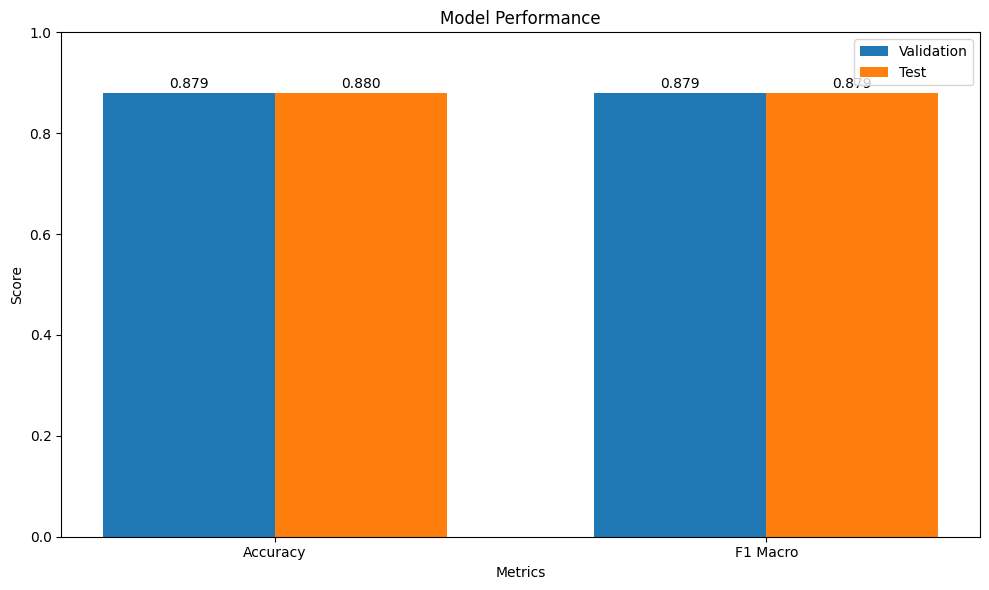


⏳ Generating detailed test metrics...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


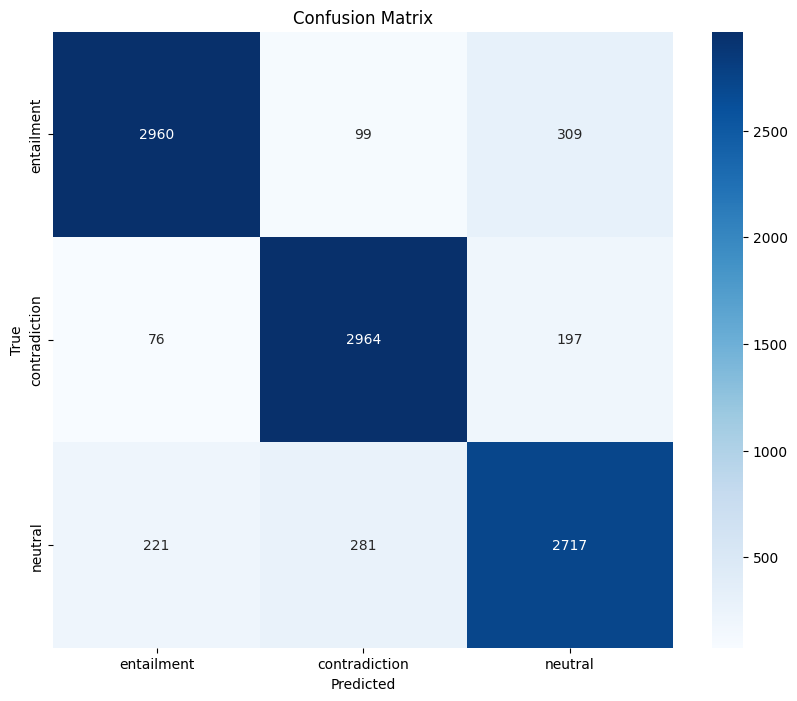


📝 Generating submission files...
Processing validation file...


Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

✅ Validation submission file saved to /kaggle/working/nli_model_20250401_195419/validation_submission.tsv
Processing test file...


Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

✅ Test submission file saved to /kaggle/working/nli_model_20250401_195419/test_submission.tsv

🔍 Validation Prediction Analysis:
Accuracy: 0.8793 (on 9842 labeled examples)

Prediction distribution:
predicted_label
contradiction    3318
neutral          3263
entailment       3261
Name: count, dtype: int64

Accuracy by class:
entailment: 0.8895 (3329 examples)
contradiction: 0.8996 (3278 examples)
neutral: 0.8482 (3235 examples)

Found 0 rows with None values in the validation set Label column.
Found 0 rows with '-' values in the validation set Label column.

✅ Evaluation complete and submission files generated!
Validation file: /kaggle/working/nli_model_20250401_195419/validation_submission.tsv
Test file: /kaggle/working/nli_model_20250401_195419/test_submission.tsv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix, classification_report
from datasets import Dataset


def extract_sentence(parse_str):
    """Extract plain text from parse tree"""
    return ' '.join(re.findall(r'\b\w+\b', str(parse_str)))

def format_instruction_examples(dataset):
    """Convert dataset examples to instruction format"""
    formatted_dataset = []
    
    # Process each example
    for i in range(len(dataset)):
        example = dataset[i]
        
        if 'Sent1_parse' in example and 'Sent2_parse' in example:
            premise_raw = example['Sent1_parse']
            hypothesis_raw = example['Sent2_parse']
            
            premise = extract_sentence(premise_raw)
            hypothesis = extract_sentence(hypothesis_raw)
            
            # Format as instruction
            instruction = f"""
Task: Determine if the premise entails, contradicts, or is neutral to the hypothesis.

Premise: {premise}
Hypothesis: {hypothesis}

Answer with only one word: entailment, contradiction, or neutral.
"""
            
            # For training examples, get label if available
            label = None
            if 'Label' in example:
                label_text = example['Label']
                if isinstance(label_text, str) and label_text != "-":
                    if label_text == 'entailment':
                        label = 0
                    elif label_text == 'contradiction':
                        label = 1
                    elif label_text == 'neutral':
                        label = 2
            
            formatted_dataset.append({
                "input": instruction,
                "label": label
            })
    
    return Dataset.from_list(formatted_dataset)

def prepare_tokenized_datasets(train_dataset, val_dataset, test_dataset):
    """
    Prepare tokenized datasets for evaluation
    """
    print("\nPreparing tokenized datasets for evaluation...")
    
    # Initialize tokenizer
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
    # Convert to instruction format
    train_instruction = format_instruction_examples(train_dataset)
    val_instruction = format_instruction_examples(val_dataset)
    test_instruction = format_instruction_examples(test_dataset)
    
    # Create tokenization function
    def tokenize_function(examples):
        return tokenizer(examples["input"], truncation=True, padding="max_length", max_length=256)
    
    # Tokenize datasets
    train_tokenized = train_instruction.map(tokenize_function, batched=True)
    val_tokenized = val_instruction.map(tokenize_function, batched=True)
    test_tokenized = test_instruction.map(tokenize_function, batched=True)
    
    # Set format for PyTorch
    train_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    val_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    test_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    
    print(f"Tokenized dataset sizes: Train={len(train_tokenized)}, Val={len(val_tokenized)}, Test={len(test_tokenized)}")
    
    return train_tokenized, val_tokenized, test_tokenized, tokenizer

def plot_results(val_metrics, test_metrics, id2label, output_dir):
    """
    Create visualizations of model performance
    """
    # Create bar chart comparing validation and test metrics
    metrics = ['accuracy', 'f1_macro']
    val_values = [val_metrics['eval_' + m] for m in metrics]
    test_values = [test_metrics['eval_' + m] for m in metrics]
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, val_values, width, label='Validation')
    plt.bar(x + width/2, test_values, width, label='Test')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance')
    plt.xticks(x, ['Accuracy', 'F1 Macro'])
    plt.legend()
    plt.ylim(0, 1.0)
    
    for i, v in enumerate(val_values):
        plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center')
    
    for i, v in enumerate(test_values):
        plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/model_performance.png')
    plt.show()

def generate_confusion_matrix(trainer, test_tokenized, id2label, output_dir):
    """
    Generate and save confusion matrix visualization
    Uses tokenized test dataset
    """
    print("\n⏳ Generating detailed test metrics...")
    test_preds = trainer.predict(test_tokenized)
    preds = np.argmax(test_preds.predictions, axis=-1)
    labels = test_preds.label_ids
    
    # Create confusion matrix
    cm = confusion_matrix(labels, preds)
    
    
    label_names = list(id2label.values())
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, 
                yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    confusion_matrix_path = f"{output_dir}/confusion_matrix.png"
    plt.savefig(confusion_matrix_path)
    plt.show()
    
    # Generate classification report
    report = classification_report(labels, preds, 
                                  target_names=label_names, 
                                  output_dict=True)
    
    # Save the classification report as a text file
    with open(f"{output_dir}/classification_report.txt", 'w') as f:
        f.write(classification_report(labels, preds, target_names=label_names))
    
    return report

def generate_submission_files(trainer, tokenizer, val_df, test_df, id2label, output_dir):
    """
    Generate prediction files in the required format for submission
    Adds predictions as the last column of the original TSV files
    """
    print("\n📝 Generating submission files...")
    
    # Process validation file
    print("Processing validation file...")
    val_examples = []
    for idx, row in val_df.iterrows():
        premise = extract_sentence(row['Sent1_parse'])
        hypothesis = extract_sentence(row['Sent2_parse'])
        
        instruction = f"""
Task: Determine if the premise entails, contradicts, or is neutral to the hypothesis.

Premise: {premise}
Hypothesis: {hypothesis}

Answer with only one word: entailment, contradiction, or neutral.
"""
        val_examples.append({"input": instruction})
    
    val_instruction_dataset = Dataset.from_list(val_examples)
    
    # Tokenize
    def tokenize_function(examples):
        return tokenizer(examples["input"], truncation=True, padding="max_length", max_length=256)
    
    val_tokenized = val_instruction_dataset.map(tokenize_function, batched=True)
    val_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask"])
    
    # Generate predictions
    val_predictions = trainer.predict(val_tokenized)
    val_pred_labels = np.argmax(val_predictions.predictions, axis=1)
    val_pred_text = [id2label[i] for i in val_pred_labels]
    
    # Add to original dataframe
    val_df_with_preds = val_df.copy()
    val_df_with_preds['predicted_label'] = val_pred_text
    val_submission_path = f"{output_dir}/validation_submission.tsv"
    val_df_with_preds.to_csv(val_submission_path, sep='\t', index=False)
    print(f"✅ Validation submission file saved to {val_submission_path}")
    
    # Process test file
    print("Processing test file...")
    test_examples = []
    for idx, row in test_df.iterrows():
        premise = extract_sentence(row['Sent1_parse'])
        hypothesis = extract_sentence(row['Sent2_parse'])
        
        instruction = f"""
Task: Determine if the premise entails, contradicts, or is neutral to the hypothesis.

Premise: {premise}
Hypothesis: {hypothesis}

Answer with only one word: entailment, contradiction, or neutral.
"""
        test_examples.append({"input": instruction})
    
    test_instruction_dataset = Dataset.from_list(test_examples)
    test_tokenized = test_instruction_dataset.map(tokenize_function, batched=True)
    test_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask"])
    
    # Generate predictions
    test_predictions = trainer.predict(test_tokenized)
    test_pred_labels = np.argmax(test_predictions.predictions, axis=1)
    test_pred_text = [id2label[i] for i in test_pred_labels]
    
    # Add to original dataframe
    test_df_with_preds = test_df.copy()
    test_df_with_preds['predicted_label'] = test_pred_text
    test_submission_path = f"{output_dir}/test_submission.tsv"
    test_df_with_preds.to_csv(test_submission_path, sep='\t', index=False)
    print(f"✅ Test submission file saved to {test_submission_path}")
    
    return val_df_with_preds, test_df_with_preds

def analyze_validation_results(val_df_with_preds):
    """
    Analyze validation prediction results in detail
    """
    print("\n🔍 Validation Prediction Analysis:")
    if 'Label' in val_df_with_preds.columns and 'predicted_label' in val_df_with_preds.columns:
        # Drop rows with None labels or "-" before calculating accuracy
        valid_rows = val_df_with_preds.dropna(subset=['Label'])
        valid_rows = valid_rows[valid_rows['Label'] != "-"]
        
        if len(valid_rows) > 0:
            # Count correct/incorrect predictions
            valid_rows['is_correct'] = valid_rows['Label'] == valid_rows['predicted_label']
            accuracy = valid_rows['is_correct'].mean()
            print(f"Accuracy: {accuracy:.4f} (on {len(valid_rows)} labeled examples)")
            
            # Count predictions by class
            print("\nPrediction distribution:")
            print(val_df_with_preds['predicted_label'].value_counts())
            
            # Check accuracy by class
            print("\nAccuracy by class:")
            for label in ['entailment', 'contradiction', 'neutral']:
                class_rows = valid_rows[valid_rows['Label'] == label]
                if len(class_rows) > 0:
                    class_acc = class_rows['is_correct'].mean()
                    print(f"{label}: {class_acc:.4f} ({len(class_rows)} examples)")
        else:
            print("No valid labeled examples found for evaluation.")
    else:
        print("Required columns 'Label' or 'predicted_label' not found in validation data.")

    # Count None and "-" values in the original dataset
    if 'Label' in val_df_with_preds.columns:
        none_count = val_df_with_preds['Label'].isna().sum()
        dash_count = (val_df_with_preds['Label'] == "-").sum()
        print(f"\nFound {none_count} rows with None values in the validation set Label column.")
        print(f"Found {dash_count} rows with '-' values in the validation set Label column.")

# Execute the evaluation and submission
print("=" * 60)
print("📊 Evaluating Model and Generating Submission Files")
print("=" * 60)

# We need to recreate the tokenized datasets 
# First, make sure we have access to the original datasets and trained model
train_tokenized, val_tokenized, test_tokenized, new_tokenizer = prepare_tokenized_datasets(
    train_dataset, val_dataset, test_dataset
)

# If tokenizer wasn't saved properly, use the newly created one
if 'tokenizer' not in globals():
    tokenizer = new_tokenizer

# Plot metrics comparison
plot_results(val_metrics, test_metrics, id2label, output_dir)

# Generate confusion matrix and classification report
report = generate_confusion_matrix(trainer, test_tokenized, id2label, output_dir)

# Generate submission files
val_df_with_preds, test_df_with_preds = generate_submission_files(
    trainer, tokenizer, val_df, test_df, id2label, output_dir
)

# Analyze validation results
analyze_validation_results(val_df_with_preds)

print("\n✅ Evaluation complete and submission files generated!")
print(f"Validation file: {output_dir}/validation_submission.tsv")
print(f"Test file: {output_dir}/test_submission.tsv")

In [20]:
# Create a zip file of your directory
!zip -r /kaggle/working/nli_model_20250401_195419.zip /kaggle/working/nli_model_*

print("Zip file created, you can download it from the Output tab")
from IPython.display import FileLink
FileLink(r'nli_model_20250401_195419.zip')

  adding: kaggle/working/nli_model_20250401_195419/ (stored 0%)
  adding: kaggle/working/nli_model_20250401_195419/best-model/ (stored 0%)
  adding: kaggle/working/nli_model_20250401_195419/best-model/config.json (deflated 51%)
  adding: kaggle/working/nli_model_20250401_195419/best-model/model.safetensors (deflated 7%)
  adding: kaggle/working/nli_model_20250401_195419/best-model/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/nli_model_20250401_195419/best-model/tokenizer.json (deflated 71%)
  adding: kaggle/working/nli_model_20250401_195419/best-model/training_args.bin (deflated 51%)
  adding: kaggle/working/nli_model_20250401_195419/best-model/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/nli_model_20250401_195419/best-model/vocab.txt (deflated 53%)
  adding: kaggle/working/nli_model_20250401_195419/validation_submission.tsv (deflated 90%)
  adding: kaggle/working/nli_model_20250401_195419/classification_report.txt (deflated 61%)
  adding: kaggle/wor

/kaggle/working/nli_model_20250401_195419.zip